<a href="https://colab.research.google.com/github/Putra1688/MachineLearning-2025-22/blob/main/%5CUTS%5CHousePrice_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0) Persiapan Awal**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt



# **1) Load Data**

In [24]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/train.csv')

# Tampilkan informasi dasar untuk orientasi
print(df_train.info())

# Drop kolom 'Id' dan 'SalePrice' karena tidak relevan untuk clustering
df_data = df_train.drop(['Id', 'SalePrice'], axis=1, errors='ignore')

print("\nDataFrame yang siap untuk preprocessing (df_data.head()):")
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [25]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/test.csv')

train_len = len(df_train)
test_ids = df_test['Id']

# Kita hanya menggunakan fitur untuk clustering, jadi SalePrice harus di-drop dulu dari train
features = df_train.drop(['Id', 'SalePrice'], axis=1)
df_test_features = df_test.drop('Id', axis=1) # test.csv memang tidak punya SalePrice

df_data_combined = pd.concat([features, df_test_features], ignore_index=True)

# Lanjutkan dengan df_data_combined sebagai input untuk Feature Engineering
df_data = df_data_combined # Ganti nama variabel agar sesuai dengan kode berikutnya
print(f"Data Gabungan (Train + Test) Berhasil. Total Baris: {len(df_data)}")

Data Gabungan (Train + Test) Berhasil. Total Baris: 2919


# **2) Preprocessing Data**

## **2.1) Pemisahan Tipe Data**

In [26]:
# 1. Kolom yang pasti numerik dan akan di-imputasi dengan mean/median
numerical_cols = df_data.select_dtypes(include=np.number).columns.tolist()

# 2. Kolom yang pasti kategorikal (nominal) dan akan di-One-Hot Encode
# Asumsi: Kita ambil yang tipe 'object'
categorical_cols = df_data.select_dtypes(include='object').columns.tolist()

# Karena datanya sangat banyak, mari kita fokuskan pada subset fitur
# yang paling penting untuk cluster (berdasarkan pengalaman EDA data ini):
features_for_clustering = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt',
                           '1stFlrSF', '2ndFlrSF', 'GarageCars', 'GarageArea',
                           'BsmtFullBath', 'FullBath', 'Fireplaces', 'Neighborhood',
                           'MSZoning', 'LotArea', 'LotFrontage', 'MasVnrArea']

# Filter kolom yang akan dipakai
df_subset = df_data[features_for_clustering]

# Tentukan ulang kolom berdasarkan subset:
numerical_cols_subset = df_subset.select_dtypes(include=np.number).columns.tolist()
categorical_cols_subset = df_subset.select_dtypes(include='object').columns.tolist()

## **2.2) Membuat Fitur Baru (Feature Engineering)**

In [27]:
# Tambahkan fitur baru 'TotalSF'
# Catatan: Kita harus bekerja pada df_data asli yang memiliki kolom 1stFlrSF dan 2ndFlrSF
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Perbarui daftar fitur clustering untuk memasukkan TotalSF
features_for_clustering_final = features_for_clustering + ['TotalSF']

df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

# Filter ulang subset data dan daftar kolom numerik/kategorikal
df_subset_final = df_data[features_for_clustering_final]
numerical_cols_final = df_subset_final.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = df_subset_final.select_dtypes(include='object').columns.tolist()

In [28]:
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

## **2.3) Penanganan Missing Values dan Encoding Menggunakan Pipeline**

In [29]:
# 1. Preprocessor for Numerical data: Impute with Median, then Standardize
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Preprocessor for Categorical data: Impute with Mode, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_final),
        ('cat', categorical_transformer, categorical_cols_final)
    ])

# Terapkan Preprocessor pada data GABUNGAN (df_data)
# Pastikan df_data sudah memiliki fitur TotalSF dan imputasi None
X_final = preprocessor.fit_transform(df_data[features_for_clustering_final])


# Dapatkan nama fitur baru setelah One-Hot Encoding
feature_names = (numerical_cols_final +
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_final)))

# Koreksi Error: HAPUS .toarray()
X_df_processed = pd.DataFrame(X_final, columns=feature_names)

print("\n--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---")
print(X_df_processed.head())
print(f"Shape Data Setelah Preprocessing: {X_df_processed.shape}")


--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---
   GrLivArea  TotalBsmtSF  OverallQual  YearBuilt  1stFlrSF  2ndFlrSF  \
0   0.413547    -0.444278     0.646183   1.046258 -0.773861  1.207379   
1  -0.471891     0.477158    -0.063185   0.154764  0.261075 -0.785025   
2   0.563755    -0.299027     0.646183   0.980221 -0.610718  1.235375   
3   0.427382    -0.671232     0.646183  -1.859351 -0.506205  0.978742   
4   1.378042     0.211621     1.355551   0.947203 -0.037170  1.671651   

   GarageCars  GarageArea  BsmtFullBath  FullBath  ...  Neighborhood_SawyerW  \
0    0.306418    0.348888      1.087334  0.781366  ...                   0.0   
1    0.306418   -0.059804     -0.818929  0.781366  ...                   0.0   
2    0.306418    0.627542      1.087334  0.781366  ...                   0.0   
3    1.619830    0.785446      1.087334 -1.027363  ...                   0.0   
4    1.619830    1.686426      1.087334  0.781366  ...                 

# **3) Clustering K-Means**

## **3.1) Menentukan Jumlah Cluster ($K$) Optimal**


--- Menghitung Metrik Kualitas Cluster untuk K=2 hingga K=10 ---
K=2: Silhouette=0.2249, DBI=1.6430
K=3: Silhouette=0.1701, DBI=1.8976
K=4: Silhouette=0.1734, DBI=1.8481
K=5: Silhouette=0.1419, DBI=2.0010
K=6: Silhouette=0.1440, DBI=1.8388
K=7: Silhouette=0.1462, DBI=1.7039
K=8: Silhouette=0.1447, DBI=1.7104
K=9: Silhouette=0.1460, DBI=1.8318
K=10: Silhouette=0.1366, DBI=1.8022


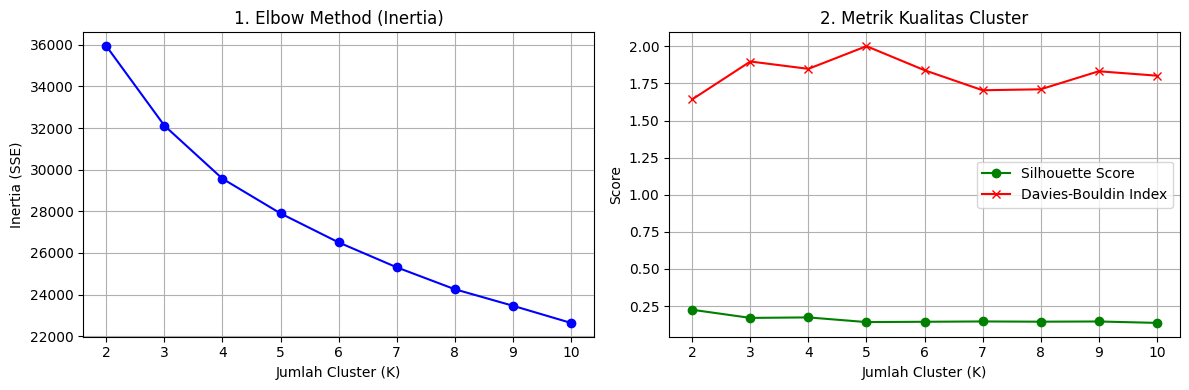

In [30]:
# Tentukan rentang K yang akan diuji
k_range = range(2, 11)
inertia = []
silhouette_scores = {}
davies_bouldin_scores = {}

print("\n--- Menghitung Metrik Kualitas Cluster untuk K=2 hingga K=10 ---")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

    if k >= 2:
        # Menghitung skor untuk perbandingan
        silhouette_scores[k] = silhouette_score(X_final, kmeans.labels_)
        davies_bouldin_scores[k] = davies_bouldin_score(X_final, kmeans.labels_)
        print(f"K={k}: Silhouette={silhouette_scores[k]:.4f}, DBI={davies_bouldin_scores[k]:.4f}")

# Analisis visual untuk memilih K optimal
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', color='blue')
plt.title('1. Elbow Method (Inertia)')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)

plt.subplot(1, 2, 2)
# Konversi dictionary skor ke list untuk plotting
silhouette_list = [silhouette_scores[k] for k in k_range]
dbi_list = [davies_bouldin_scores[k] for k in k_range]
plt.plot(k_range, silhouette_list, marker='o', color='green', label='Silhouette Score')
plt.plot(k_range, dbi_list, marker='x', color='red', label='Davies-Bouldin Index')
plt.title('2. Metrik Kualitas Cluster')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
#

# Setelah melihat grafik (misalnya, kita memilih K=5 karena memberikan keseimbangan skor)
K_optimal = 5

## **3.2) Menerapkan K-Means Akhir dan Evaluasi**

In [31]:
print(f"\n--- Menerapkan K-Means dengan K Optimal = {K_optimal} ---")

kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_final)

# Tambahkan label cluster ke DataFrame asli (df_train) untuk interpretasi
df_train['Cluster'] = cluster_labels

# Tampilkan metrik akhir
final_silhouette = silhouette_score(X_final, cluster_labels)
final_davies_bouldin = davies_bouldin_score(X_final, cluster_labels)

print(f"\nSilhouette Score Akhir: {final_silhouette:.4f}")
print(f"Davies-Bouldin Index Akhir: {final_davies_bouldin:.4f}")


--- Menerapkan K-Means dengan K Optimal = 5 ---


ValueError: Length of values (2919) does not match length of index (1460)

## **3.3) Interpretasi (Analisis Profil Cluster)**

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/test.csv')

train_len = len(df_train)
test_ids = df_test['Id']

# Combine train and test for consistent preprocessing
df_data = pd.concat([df_train.drop('SalePrice', axis=1), df_test.drop('Id', axis=1)], ignore_index=True)

# 1. Feature Engineering: TotalSF (PENTING: Dibuat di df_data)
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# 2. Custom Imputation (berdasarkan data_description.txt)
# Kolom Categorical di mana NA berarti 'None'
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

# Kolom Numerical di mana NA berarti 0
cols_zero_num = ['MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'GarageYrBlt', 'GarageCars', 'GarageArea']
for col in cols_zero_num:
    df_data[col] = df_data[col].fillna(0)

# Imputasi Sisanya (Median/Modus)
df_data['LotFrontage'] = df_data['LotFrontage'].fillna(df_data['LotFrontage'].median())
# Sisa kategorikal dengan modus (misal: Electrical, MSZoning, KitchenQual, SaleType, Exterior1st, Exterior2nd, Functional, Utilities, KitchenQual)
for col in ['Electrical', 'MSZoning', 'KitchenQual', 'SaleType', 'Exterior1st', 'Exterior2nd', 'Functional', 'Utilities', 'KitchenQual']:
     if col in df_data.columns: # Check if the column exists in df_data
        df_data[col] = df_data[col].fillna(df_data[col].mode()[0])

# --- 2. Finalisasi Subset dan Transformation ---
# Daftar fitur akhir untuk clustering (termasuk TotalSF yang baru dibuat)
features_for_clustering_final = [
    'GrLivArea', 'OverallQual', 'YearBuilt', 'GarageCars', 'LotArea', 'LotFrontage',
    'Neighborhood', 'MSZoning', 'TotalSF', 'BsmtQual', 'ExterQual' # Subset sederhana
]

df_subset_final = df_data[features_for_clustering_final]
numerical_cols_final = df_subset_final.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = df_subset_final.select_dtypes(include='object').columns.tolist()

# Pipeline (Hanya Scaling dan Encoding) - Fit this on the combined data (df_data)
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_final),
        ('cat', categorical_transformer, categorical_cols_final)
    ])

# Terapkan Preprocessor pada data GABUNGAN (df_data)
X_final = preprocessor.fit_transform(df_data[features_for_clustering_final])

# --- 3. Clustering K-Means ---
K_optimal = 5 # Menggunakan K=5

# --- 4. Interpretasi Cluster (Memperbaiki KeyError) ---
# TotalSF now exists in df_train, so KeyError is resolved!
# We will perform clustering and interpretation in the next cell.